In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
import ast
import requests
import os

# Brief analysis of the data

In [92]:
# Import movies dataset
movie_metadata = pd.read_csv('dataset/MovieSummaries/movie.metadata.tsv', sep='\t', header=None , 
names=['WikiID', 'FreebaseID', 'Name', 'Release', 'BoxRevenue', 'Runtime', 'Languages', 'Countries', 'Genres'])
movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [93]:
# Preprocessing dataset: convert dates to datetime, countries, genres and languages to string
movie_metadata["Release"] = movie_metadata["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce')).apply(lambda x: x.strftime('%Y') if pd.notnull(x) else x)
movie_metadata["Countries"] = movie_metadata["Countries"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Languages"] = movie_metadata["Languages"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Genres"] = movie_metadata["Genres"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)


movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [94]:
# Explode countries for visualization
processed = movie_metadata
processed = processed.explode(column="Countries").reset_index(drop = True)
processed.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],Germany,[Drama]


Countries
United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
Name: Name, dtype: int64


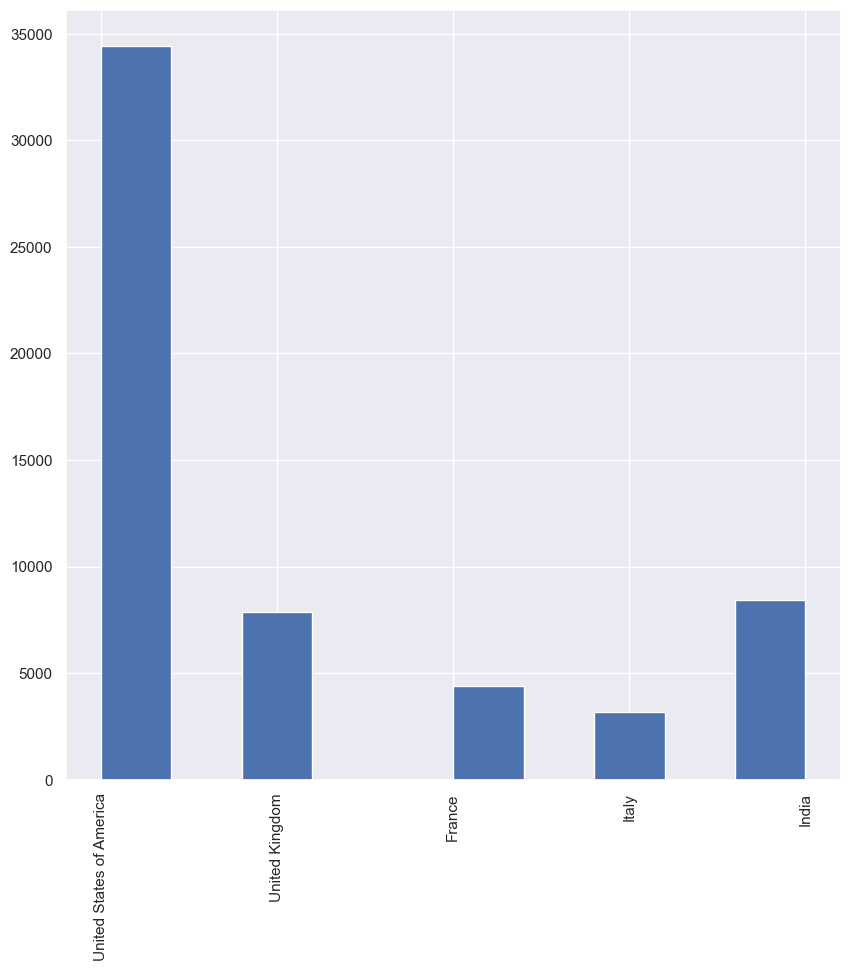

In [95]:
# Plot histogram of the countries with the most productions
k = processed.groupby(by="Countries")["Name"].count().nlargest(5).index
pruned = processed[processed["Countries"].apply(lambda x: x in k)]
pruned["Countries"].hist()
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("darkgrid")
print(processed.groupby(by="Countries")["Name"].count().nlargest(5, "all").sort_values(ascending=False))

<AxesSubplot:xlabel='Release', ylabel='Countries'>

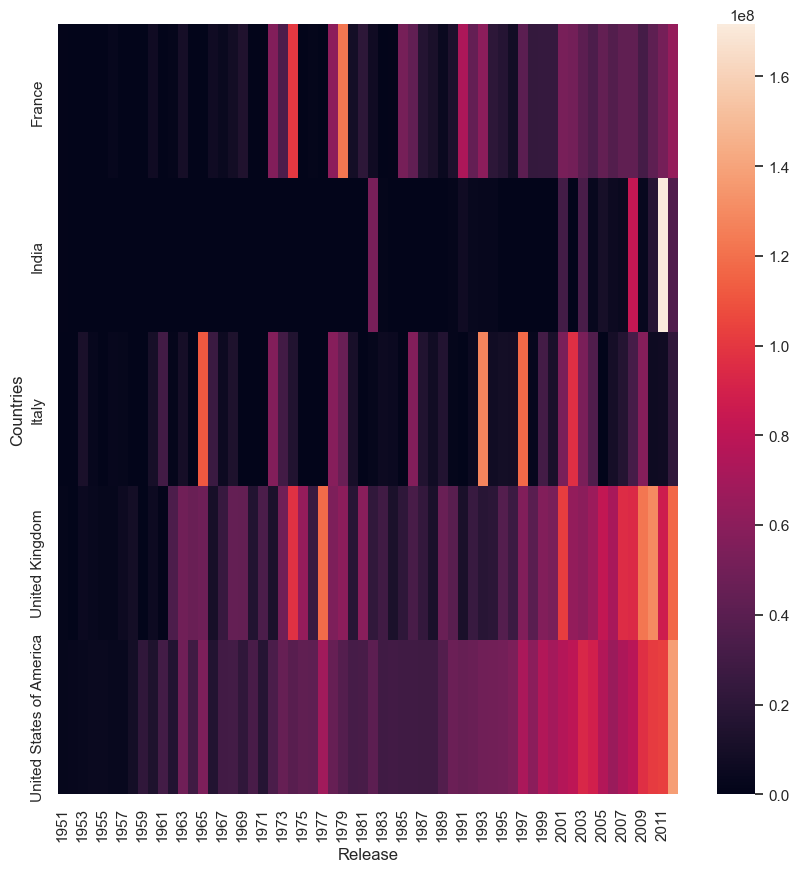

In [96]:
# What are the most common genres for the 5 top producing countries
temp = pruned[pruned["Release"].notna()]
temp = temp[temp["Release"].astype(float)>1950].pivot_table(index = 'Countries', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
sns.heatmap(temp)

Text(0.5, 1.0, 'Box revenue UK')

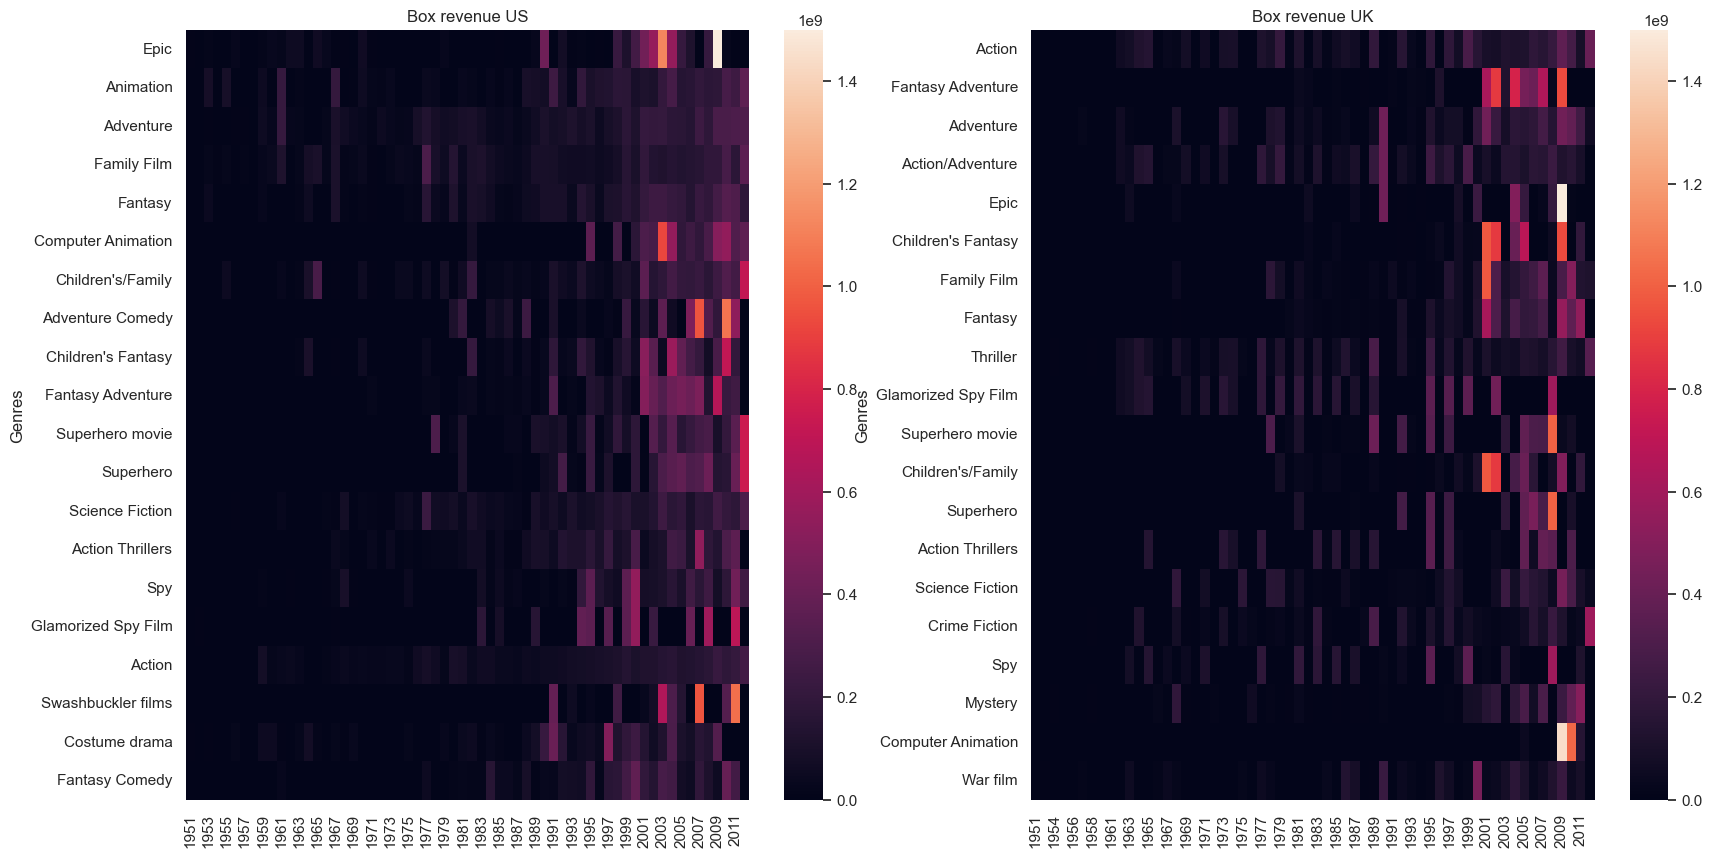

In [97]:
# Box revenue of genres vs release date for the US
exploded = pruned[pruned["Countries"].apply(lambda x: x =="United States of America" )].explode("Genres")
tmp = exploded.pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
d = tmp.apply(lambda x: sum(x), axis = 1)
d.name = 'tmp'
tmp = pd.concat([tmp, d], axis=1).nlargest(20, 'tmp').drop('tmp', axis=1)
tmp = tmp.loc[:, tmp.apply(lambda x: int(x.name)>1950, axis = 0)]
# Box revenue of genres vs release date for the UK
exploded = pruned[pruned["Countries"].apply(lambda x: x =="United Kingdom" )].explode("Genres")
temp = exploded[exploded["Release"].notna()]
temp = temp[temp["Release"].astype(float)>1950].pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
d = temp.apply(lambda x: sum(x), axis = 1)
d.name = 'temp'
temp = pd.concat([temp, d], axis=1).nlargest(20, "temp").drop('temp', axis=1)
# The max values has been fixed at 1.5e9
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1 = sns.heatmap(tmp, ax = ax1, vmax=1.5e9)
ax1.set_title("Box revenue US")
ax2 = sns.heatmap(temp, ax=ax2, vmax=1.5e9)
ax2.set_title("Box revenue UK")


<AxesSubplot:ylabel='Genres'>

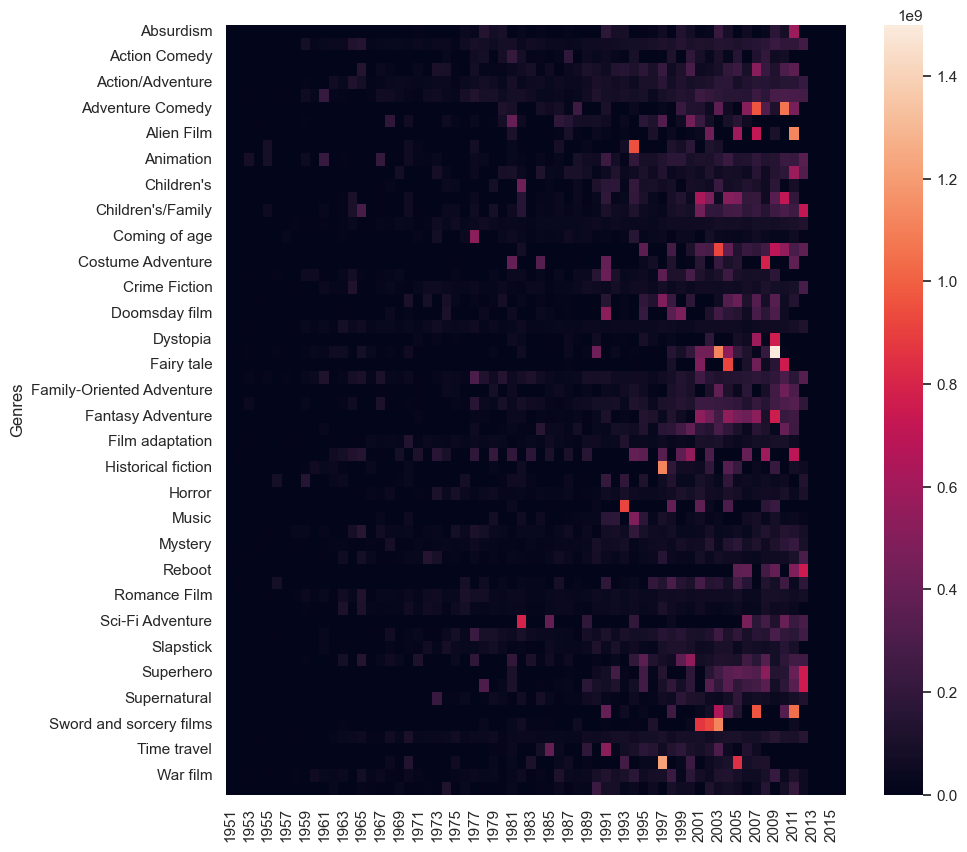

In [98]:
# BoxRevenue globally
exploded = pruned.explode("Genres")
tmp = exploded.pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0, dropna=False)
d = tmp.apply(lambda x: x.sum(skipna=True), axis = 1)
d.name = 'tmp'
tmp = pd.concat([tmp, d], axis=1).nlargest(60, 'tmp').drop('tmp', axis=1)
tmp = tmp.loc[:, tmp.apply(lambda x: int(x.name)>1950, axis = 0)]
tmp = tmp.sort_index()
# The max value has been fixed at 1.5e9 for better visualization
sns.heatmap(tmp, vmax=1.5e9)

In [99]:
# Import characters dataset and preprocessing
characters = pd.read_csv('dataset/MovieSummaries/character.metadata.tsv', sep='\t', header=None, 
names = ["WikiID", "FreebaseID", "Release", "Character name", "Birth", 
"Gender", "Height (m)", "Ethnicity", "Name", "Age at movie release",
"Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"])
characters["Release"] = characters["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce')).apply(lambda x: x.strftime('%Y') if pd.notnull(x) else x)
characters["Birth"] = characters["Birth"].apply(lambda x: pd.to_datetime(x, errors = 'coerce')).apply(lambda x: x.strftime('%Y') if pd.notnull(x) else x)
characters.head()


,WikiID,FreebaseID,Release,Character name,Birth,Gender,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001,Akooshay,1958,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [100]:
# Generate the list of different ethnicities
ethnicities = characters['Ethnicity'].dropna().unique().tolist()

In [101]:
# Function which allows query search of ids using Wikidata SPARQL service
def get_ethnicities(ids):

  tmp = '""'.join(ids)

  url = 'https://query.wikidata.org/sparql'
  query = '''
  SELECT  ?ethnicities ?sLabel WHERE {
  VALUES ?ethnicities {"'''+tmp+'''"} 
  ?s wdt:P646 ?ethnicities .

    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "en" .
    }
  }
  '''
  r = requests.post(url, params = {'format': 'json', 'query': query})
  data = r.json()
  return data

In [102]:
d1 = get_ethnicities(ethnicities[1:200])
d2 = get_ethnicities(ethnicities[201:478])
tmp1 = []
tmp2 = []
for d in (d1, d2):
    for el in d["results"]["bindings"]:
        tmp1.append(el["ethnicities"]["value"])
        tmp2.append(el["sLabel"]["value"])
table_eth = pd.DataFrame(tmp1, tmp2).reset_index().rename(columns = {"index": "Ethnicities", 0: "code"})
table_eth.head()
# Table associating the freebase id with the ethnicities

,Ethnicities,code
0,European Americans,/m/02vsw1
1,Slavs,/m/0790v
2,German Americans,/m/01qhm_
3,Swiss,/m/025_0f0
4,Omaha people,/m/064b9n


In [103]:
"""Code for querying using Google's knowledge graph"""
import json
import urllib
# We are only going to use the Google's KG for the remaining codes that we couldn't find in WikiData 
ids = list(set(ethnicities) - set(table_eth["code"]))
# Private api key for using Google's API
if os.path.isfile("api_key.txt"):
  api_key = open("api_key.txt").read()
  service_url = 'https://kgsearch.googleapis.com/v1/entities:search'
  params = {
      'limit': 500,
      'indent': True,
      'key': api_key,
  }
  url = service_url + '?' + 'ids='+'&ids='.join(ids).replace("/", "%2F" )+'&'+urllib.parse.urlencode(params)
  response = json.loads(urllib.request.urlopen(url).read())
  for element in response['itemListElement']:
    print(element['result']['name'] + ' (' + str(element['result']["@id"]) + ')')
  tmp1 = []
  tmp2 = []
  for element in response['itemListElement']:
      tmp2.append(element['result']['name'])
      tmp1.append(element['result']["@id"].replace("kg:", ''))
  table_eth = pd.concat([table_eth, pd.DataFrame(tmp1, tmp2).reset_index().rename(columns = {"index": "Ethnicities", 0: "code"})])
table_eth.head()


Asante people (kg:/m/01flqq)
Saliya (kg:/m/071drf)
Han Chinese (kg:/m/013y54)
Samoan New Zealanders (kg:/m/0404kdr)


,Ethnicities,code
0,European Americans,/m/02vsw1
1,Slavs,/m/0790v
2,German Americans,/m/01qhm_
3,Swiss,/m/025_0f0
4,Omaha people,/m/064b9n


In [104]:
# Replace ethnicity code by value
characters["Ethnicity"] = characters["Ethnicity"].apply(lambda x: table_eth["Ethnicities"][table_eth["code"]==x].values[0]
if any(table_eth["code"]==x) else x)
characters.head()

,WikiID,FreebaseID,Release,Character name,Birth,Gender,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001,Akooshay,1958,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [105]:
# Find character which appear in the movies made by the top producing countries
charac_group = pruned.groupby(by="Countries", as_index=True).apply(lambda x: 
characters[["WikiID", "Release", "Gender", "Ethnicity","Age at movie release", "Birth"]][characters["WikiID"].isin(x["WikiID"])])
charac_group.to_pickle("data/charac_group")
charac_group.head()

WikiID Release Gender Ethnicity  Age at movie release Birth
Countries                                                                   
France    99   22087420    1959      M       NaN                  56.0  1903
          215  23215861    1982      M       NaN                   NaN  1944
          216  23215861    1982    NaN       NaN                   NaN   NaT
          217  23215861    1982      M       NaN                   NaN  1940
          218  23215861    1982      F       NaN                   NaN  1940

C:\Users\nico9\AppData\Local\Temp\ipykernel_11896\853788404.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Ethnicity"].notna()]


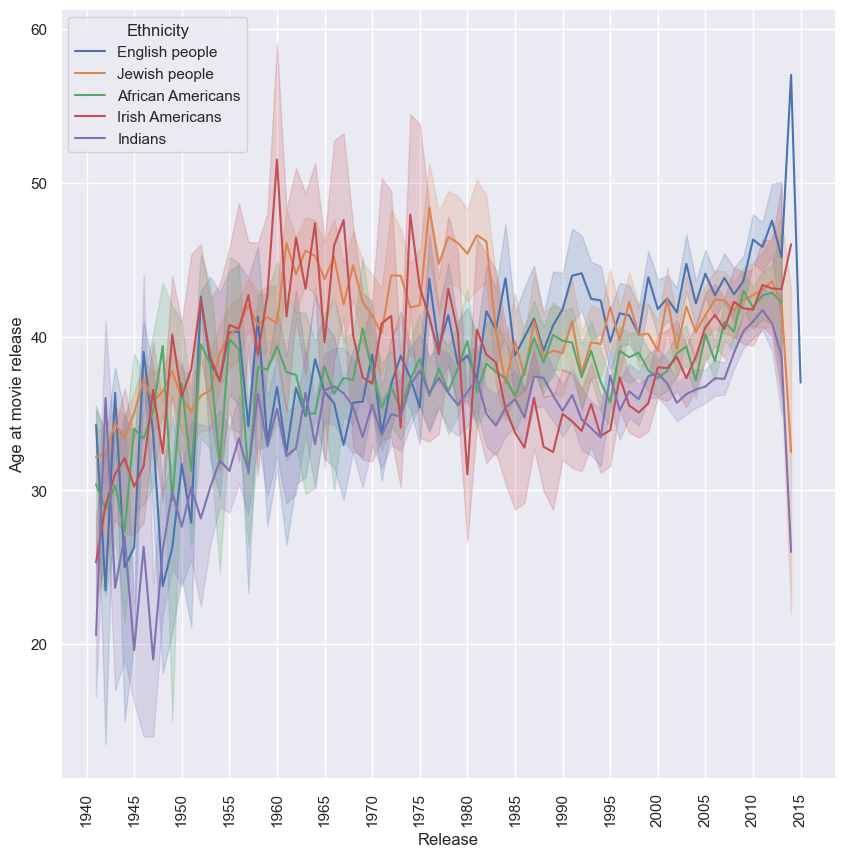

In [106]:
# Generate plot of age of people of different ethnicities vs the date of release
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Release"].notna()]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Ethnicity"].notna()]
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]

tmp["Release"] = tmp["Release"].astype(float)
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Ethnicity")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)


We had to filter all the people whoose age was >0 as the dataset contains aberrant values (negative). Furthermore, we filtered plotted only the data points for which date>1940 as the previous movies also showed an unexpected behaviour

Explanation:.....

TO DO: Find reasons why the age of people for movies <1940 is lower than 20 (of course babies are not acting rigth?)

C:\Users\nico9\AppData\Local\Temp\ipykernel_11896\167884288.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Gender"].notna()]


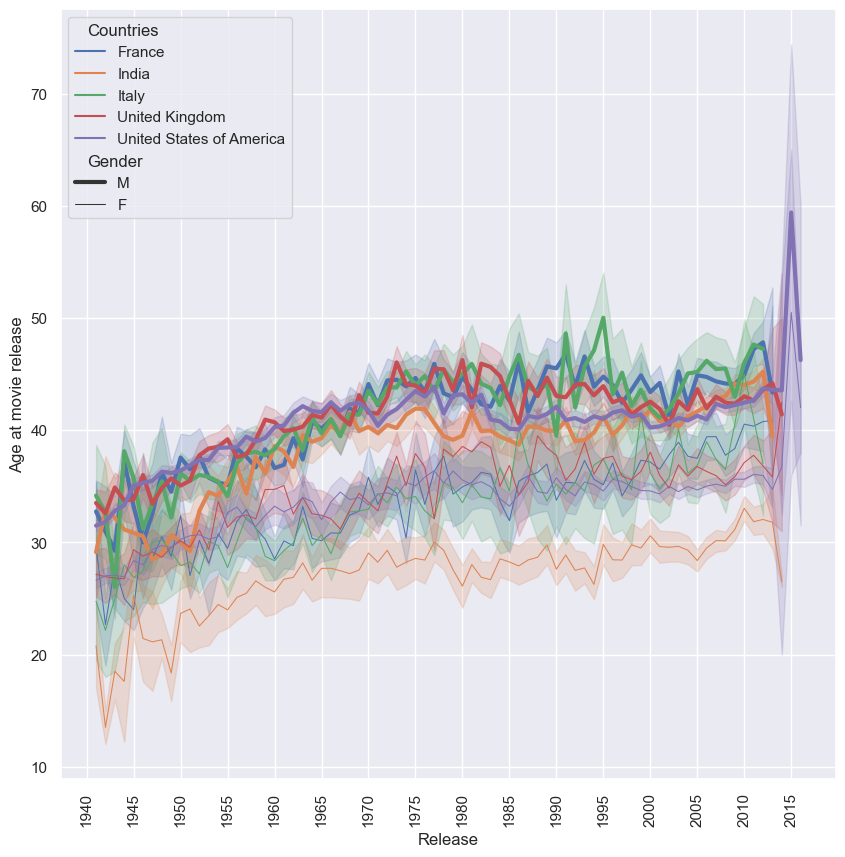

In [107]:
# Plot of age at movie release vs date of film for different countries/sex
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Release"].notna()]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Gender"].notna()]

tmp["Release"] = tmp["Release"].astype(float)
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Countries", size="Gender")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)

C:\Users\nico9\AppData\Local\Temp\ipykernel_11896\1213166072.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Release"]>1940][tmp["Release"]<2005][tmp["Ethnicity"].notna()]


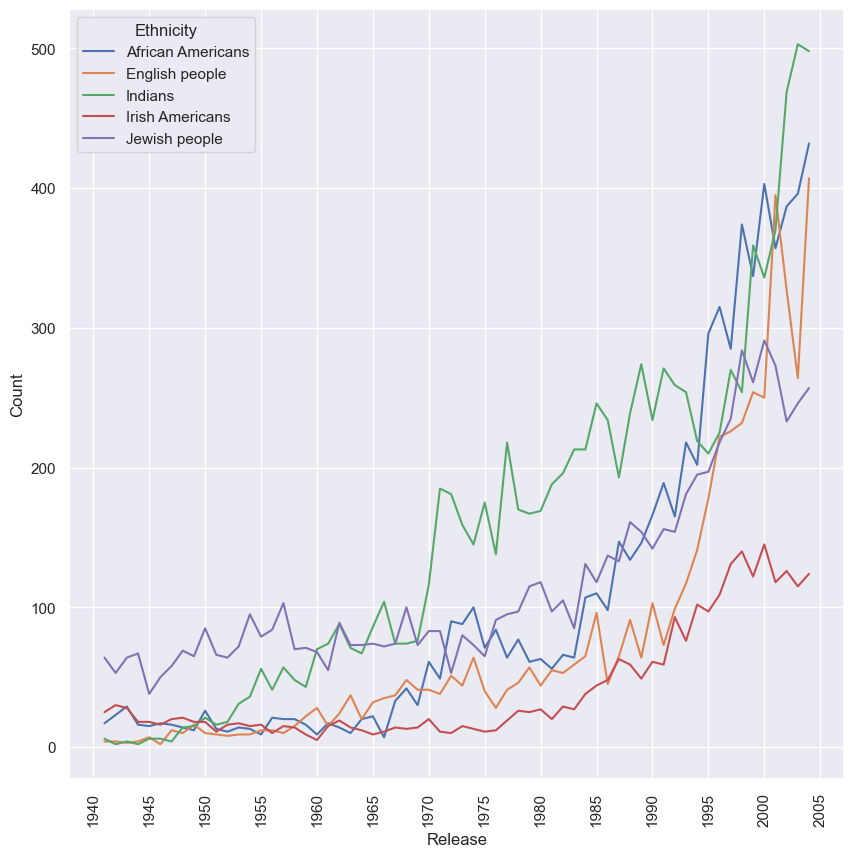

In [108]:
# Generate plot of age of people of different ethnicities vs the date of release
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Release"].notna()]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Release"]>1940][tmp["Release"]<2005][tmp["Ethnicity"].notna()]
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]

t=tmp.groupby(by=["Ethnicity", "Release"]).count().reset_index().rename(columns = {"Countries": "Count"})

sns.lineplot(data=t, x = "Release", y="Count", hue="Ethnicity")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)